# 과제 목표

2019.01~2020.03 오프라인 매장 신용카드 사용 금액을 기반으로 2020.04, 2020.07의 신용카드 사용 금액 예측하기


## 기본 구성

- 변수 : REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, HOM_SIDO_NM, HOM_CCG_NM, AGE, SEX_CTGO_CD, FLC, CSTMR_CNT, AMT, CNT
- REG_YYMM 부터 FLC 까지의 컬럼은 고정으로 주어지는 내용으로 결제 시점에 따라 변경 되거나 그 자체로 정량적 변화가 발생하는 것은 아니다. train 데이터인 2019.01~2020.03 의 데이터에서 카드 사용이 발생했다면 레코드가 있고, 사용이 없었다면 레코드가 없는 것으로 차이가 발생한다. 반면 CSTMR_CNT, AMT, CNT 는 각 레코드 안에서 정량적 변화가 발생하는 변수로, 결제 시점에 그 정확한 값을 알 수 있는 변수다. 그러므로 예측되어야 하는 값인 종속변수이다.

**Libraries**

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
# 현재 위치 확인

import os

print(os.getcwd())

/home/sundooedu/Creditcard-use-analysis-dev./Nukzan


In [20]:
# 한글 폰트 적용

from matplotlib import font_manager, rc
# window >
# font_name = font_manager.FontProperties(fname="/Windows/Fonts/NanumGothicCoding.ttf").get_name()
# linux >
font_name = font_manager.FontProperties(fname="../NanumGothicCoding-2.5/NanumGothicCoding.ttf").get_name()
# gram >
# font_name = font_manager.FontProperties(fname="/Windows/Fonts/gulim.ttc").get_name()
rc('font', family=font_name)

# Basic

In [ ]:
# zip 파일로 된 데이터 파일 풀기 - Data 폴더에 압축 풀기

import zipfile
with zipfile.ZipFile("../Data/jeju_data_ver1(원본).zip","r") as zip_ref:
    zip_ref.extractall("./")

In [5]:
jeju = pd.read_csv('./201901-202003.csv')

In [8]:
# jeju.describe(), jeju.info()
jeju.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

결측값이 약 20만개정도 있는 것을 확인할 수 있다.

In [11]:
jeju[jeju['HOM_CCG_NM'].isnull()]

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
420,201901,강원,강릉시,과실 및 채소 소매업,세종,NaN,30s,1,2,3,58000,3
421,201901,강원,강릉시,과실 및 채소 소매업,세종,NaN,40s,1,3,3,263000,4
1189,201901,강원,강릉시,기타 대형 종합 소매업,세종,NaN,20s,1,1,3,176540,3
1190,201901,강원,강릉시,기타 대형 종합 소매업,세종,NaN,20s,2,1,4,234880,6
1191,201901,강원,강릉시,기타 대형 종합 소매업,세종,NaN,30s,1,2,4,177640,5
...,...,...,...,...,...,...,...,...,...,...,...,...
24697496,202003,충북,충주시,한식 음식점업,세종,NaN,30s,2,2,5,188500,8
24697497,202003,충북,충주시,한식 음식점업,세종,NaN,40s,1,3,18,1056500,28
24697498,202003,충북,충주시,한식 음식점업,세종,NaN,50s,1,4,25,770150,35
24697499,202003,충북,충주시,한식 음식점업,세종,NaN,50s,2,4,4,19500,4


결측값은 가맹점 시군구와 카드 사용자의 거주 시군구이다.\
해당 값은 시도 값이 '세종'으로, 세종의 시군구가 NaN 값으로 들어간 것을 알 수 있다.\
이후 해당 컬럼을 독립변수에서 제외 할 예정이므로, 결측값을 따로 처리하지 않는다.

In [18]:
jeju.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,TOURST
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,0
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,0
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,0
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,0
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,0


데이터 해석 : 지역-업종별 거주지 시도, 거주지 시군구, 연령대, 성별, 가족구성 유형에 따라 카드 사용 정보가 기록되어 있다.
- 예시로 첫 번째 행은 2019년 01월 강원도 강릉시의 건강보조식품 소매업에서 강원도 강릉시의 20대 남성 1인가구가 사용한 카드 정보로, 4명의 고객이 311200원을 총 4회의 카드 사용을 통해 만들었다는 내용이다.
- 각 레코드는 가맹점별 혹은 사용자 1인별 정보가 아닌 해당 조건에 해당하는 것들을 묶어서 나타낸 것이다.
- 카드 이용자(a)와 카드 이용 횟수 정보(b)가 다를 경우, a > b 라면 결제 취소가 있었다는 것과 a < b 라면 재방문이 있었다는 것을 의미한다.

# Data Cleansing

In [7]:
# 날짜 처리

def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

data = jeju.copy()
data = data.fillna('')

data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))

data = data.drop(['REG_YYMM'], axis = 1)

data

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,month,year
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,1,2019
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,1,2019
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,1,2019
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,1,2019
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,3,2020
24697788,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,3,2020
24697789,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,3,2020
24697790,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,3,2020


In [8]:
# 데이터 정제

data = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis = 1)

columns =['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE',
          'SEX_CTGO_CD', 'FLC', 'year', 'month']
data = data.groupby(columns).sum().reset_index(drop = False)
data

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3
...,...,...,...,...,...,...,...,...,...,...,...
1057389,충북,휴양콘도 운영업,충북,70s,2,5,2019,3,3,148000,4
1057390,충북,휴양콘도 운영업,충북,70s,2,5,2019,5,5,329800,7
1057391,충북,휴양콘도 운영업,충북,70s,2,5,2019,10,7,557800,7
1057392,충북,휴양콘도 운영업,충북,70s,2,5,2019,12,3,247800,3


In [9]:
# 인코딩
# Object 문자로 된 컬럼은 LabelEncoder로 인덱스 도출 (범주형 데이터를 dummies화 시켜서 one-hot 인코딩 사용하는 것과 비슷한 기능)
from sklearn.preprocessing import LabelEncoder

dtypes = data.dtypes
encoders = {}

for column in data.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(data[column])
        encoders[column] = encoder
        
data_num = data.copy()
for column in encoders.keys():
    encoder = encoders[column]
    data_num[column] = encoder.transform(data[column])
    
data_num

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT
0,0,0,0,1,1,1,2019,1,4,311200,4
1,0,0,0,1,1,1,2019,2,3,605000,3
2,0,0,0,1,1,1,2019,6,3,139000,3
3,0,0,0,1,1,1,2019,8,3,27500,3
4,0,0,0,1,1,1,2019,9,3,395500,3
...,...,...,...,...,...,...,...,...,...,...,...
1057389,16,40,16,6,2,5,2019,3,3,148000,4
1057390,16,40,16,6,2,5,2019,5,5,329800,7
1057391,16,40,16,6,2,5,2019,10,7,557800,7
1057392,16,40,16,6,2,5,2019,12,3,247800,3


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
# ym_cnt = np.unique(jeju.REG_YYMM.values)

# corr_arr = np.zeros((len(ym_cnt),len(ym_cnt)))
# corr_arr = pd.DataFrame(corr_arr,columns=ym_cnt, index=ym_cnt)

# for i in ym_cnt:
#     for j in ym_cnt:
#         t1 = jeju[jeju['REG_YYMM'].values == i]  
#         t2 = jeju[jeju['REG_YYMM'].values == j]
#         corr = np.corrcoef(t1.AMT.values,t2.AMT.values)[0][1] 
        
#         corr_arr.loc[i,j]=round(corr,3)
        
# plt.figure(figsize=(10,10))
# sns.heatmap(corr_arr)

관광객 / 비관광객 컬럼 도출

In [11]:
# 0은 현지인, 1은 관광객

jeju['TOURST'] = (jeju['CARD_SIDO_NM']!=jeju['HOM_SIDO_NM']).astype(int)

jeju

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,TOURST
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,0
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,0
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,0
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,0
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,0
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,0
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,0
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,0


In [21]:
len(jeju[jeju['TOURST'] == 1])/len(jeju)

0.6063921017716888

약 60퍼센트의 레코드가 관광객의 레코드이다.

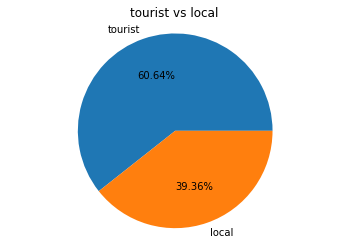

In [22]:
# information of groups

group_nm = ['tourist', 'local']
group_sz = [len(jeju[jeju['TOURST'] == 1]), len(jeju[jeju['TOURST'] == 0])]

plt.pie(group_sz, labels = group_nm, autopct = '%1.2f%%')
plt.axis('equal')
plt.title('tourist vs local')
plt.show()

# EDA

EDA 계획
1. 데이터 쏠림 현상은 없는지 확인 : 지역, 업종
2. CSTMR_CNT, AMT, CNT의 상관관계 확인
3. 사용금액 파악하기 : 지역, 업종
4. 사용금액 상위 10위, 하위 10위 비교하기

## 1. 데이터 쏠림 현상 확인하기

### 지역 분석

In [19]:
# cnt_sido = jeju.CARD_SIDO_NM.value_counts()
# plt.figure(figsize = (12,8))
# sns.barplot(cnt_sido.index, cnt_sido.values, alpha=0.8)

# plt.show()

In [71]:
sido_counts = jeju.CARD_SIDO_NM.value_counts().reset_index(drop = False)
sido_counts

sido_counts = pd.DataFrame(sido_counts)
sido_counts.columns = ['지역', '레코드']
sido_counts

,지역,레코드
0,서울,6259502
1,경기,5188230
2,부산,2030810
3,인천,1278410
4,강원,1230355
5,경남,1222818
6,경북,1204831
7,충남,1178159
8,충북,834707
9,전북,829466


서울 경기 지역에 레코드 수가 몰려있는 걸 볼 수 있다.\
이는 해당 지역 시군구가 많이 나뉘어 있다는 의미일 수 있기 때문에, 각 시도별 시군구 값을 비교해보자.

In [35]:
SIDO = jeju.CARD_SIDO_NM.unique()
SIDO

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

In [59]:
sido_sigun = []

for w in SIDO:
    length_sigun = len(jeju[jeju.CARD_SIDO_NM == w]['CARD_CCG_NM'].unique())
    length = [w, length_sigun]
    sido_sigun.append(length)
    
sido_sigun = pd.DataFrame(sido_sigun, columns = ['지역', '시군 수'])

In [61]:
sido_sigun.sort_values(by=['시군 수'], axis=0,ascending=False)

,지역,시군 수
1,경기,42
8,서울,25
3,경북,24
2,경남,22
12,전남,22
0,강원,18
7,부산,16
15,충남,16
13,전북,15
16,충북,14


findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


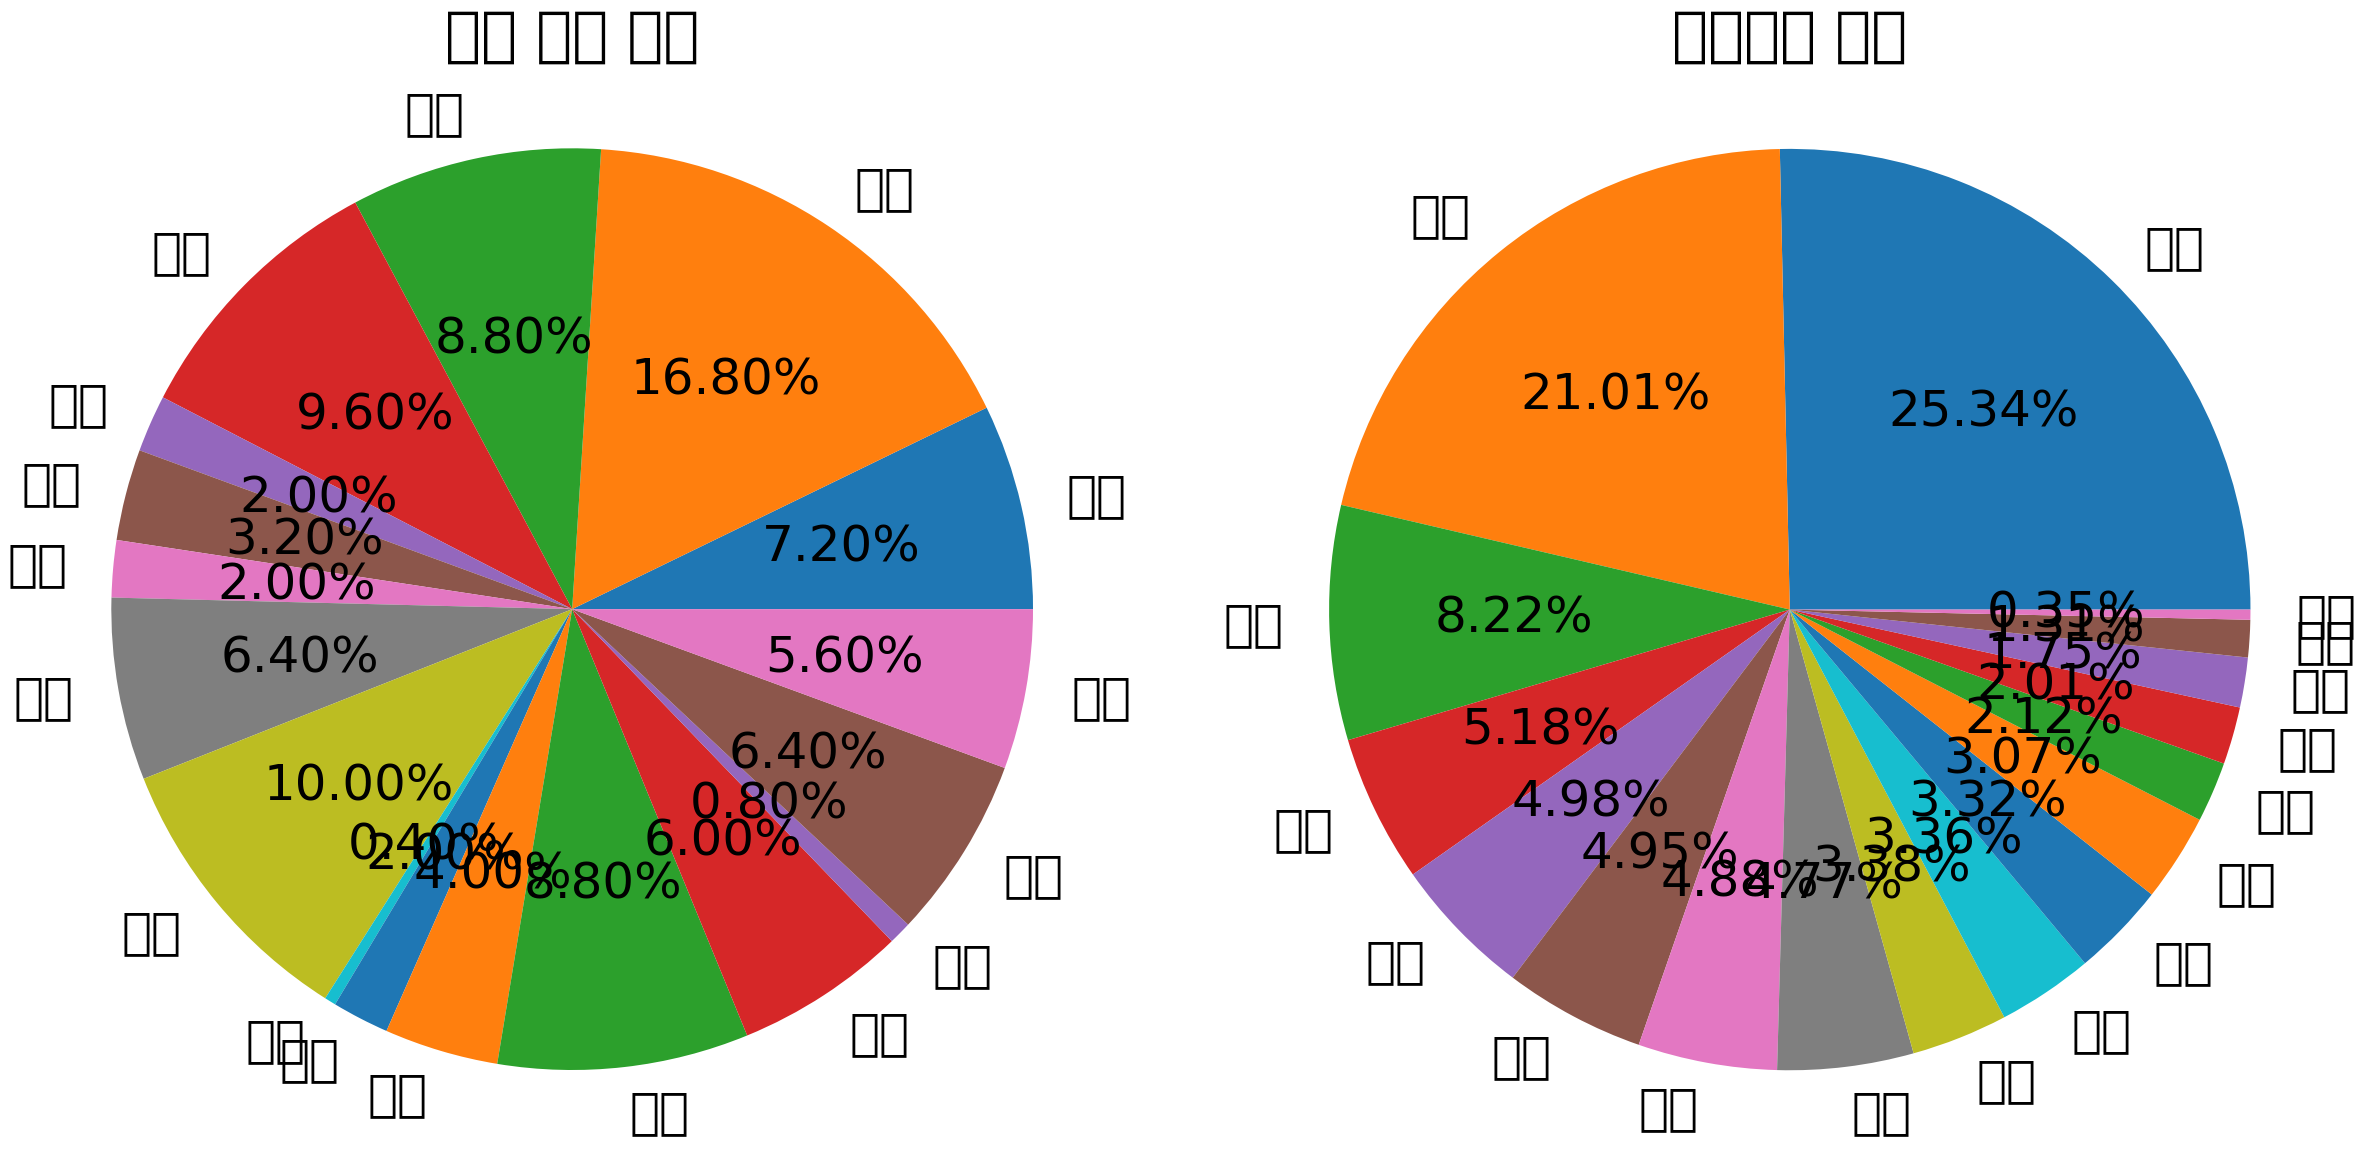

In [86]:
# 지역의 레코드 비중과 시군구 비중

plt.figure(figsize=(40, 20))
plt.rc('font', size = 50)

plt.subplot(121)
group_nm = SIDO
group_sz = sido_sigun['시군 수']

plt.pie(group_sz, labels = group_nm, autopct = '%1.2f%%')
plt.axis('equal')
plt.title('시군 수의 비중')

plt.subplot(122)
group_nm1 = SIDO
group_sz1 = sido_counts['레코드']

plt.pie(group_sz1, labels = group_nm1, autopct = '%1.2f%%')
plt.axis('equal')
plt.title('레코드의 비중')

plt.show()

하지만 해당 데이터는 레코드가 각각 소비 건수나 고객 1인이 아니므로 CNT와 CSTMR_CNT와 비교해봐야한다.

In [19]:
card_cnt_sido = jeju.groupby(['CARD_SIDO_NM'])['CNT'].sum().reset_index(drop = False)
card_cnt_sido.sort_values(by=['CNT'], axis=0,ascending=False)

,CARD_SIDO_NM,CNT
8,서울,994077624
1,경기,701143788
7,부산,228178463
5,대구,164232841
2,경남,149370331
11,인천,147173793
3,경북,113078004
15,충남,91093453
4,광주,82758813
13,전북,80723851


In [20]:
card_cnt_sido = jeju.groupby(['CARD_SIDO_NM'])['CSTMR_CNT'].sum().reset_index(drop = False)
card_cnt_sido.sort_values(by=['CSTMR_CNT'], axis=0,ascending=False)

,CARD_SIDO_NM,CSTMR_CNT
8,서울,444724002
1,경기,345133871
7,부산,119843370
5,대구,83085072
2,경남,78397280
11,인천,72829668
3,경북,59718037
15,충남,47135876
13,전북,43902437
4,광주,43127377


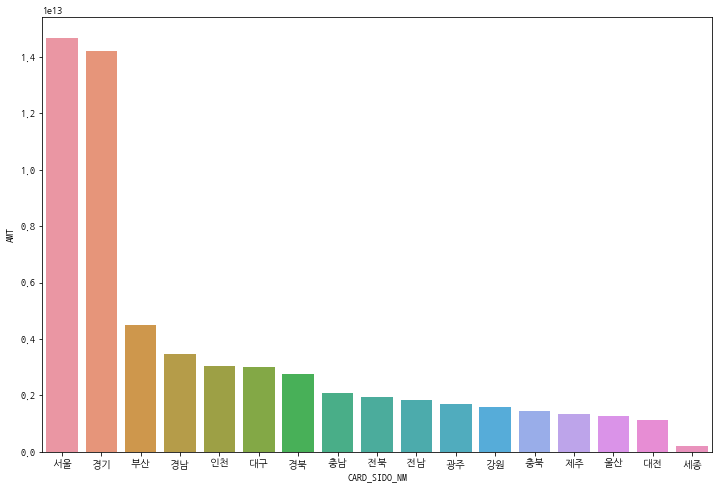

In [38]:
card_sido = jeju.groupby(['CARD_SIDO_NM'])['AMT'].sum().reset_index(drop = False)
card_sido = card_sido.sort_values(by=['AMT'], axis=0,ascending=False)
plt.figure(figsize = (12,8))
sns.barplot(card_sido.CARD_SIDO_NM, card_sido.AMT)

plt.show()

다만, 데이터 볼륨이 큰만큼 카드 이용 금액도 서울 경기에 월등히 몰려있는 것을 볼 수 있다.

### 업종 분석

/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backe

/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 52649 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/sundooedu/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backen

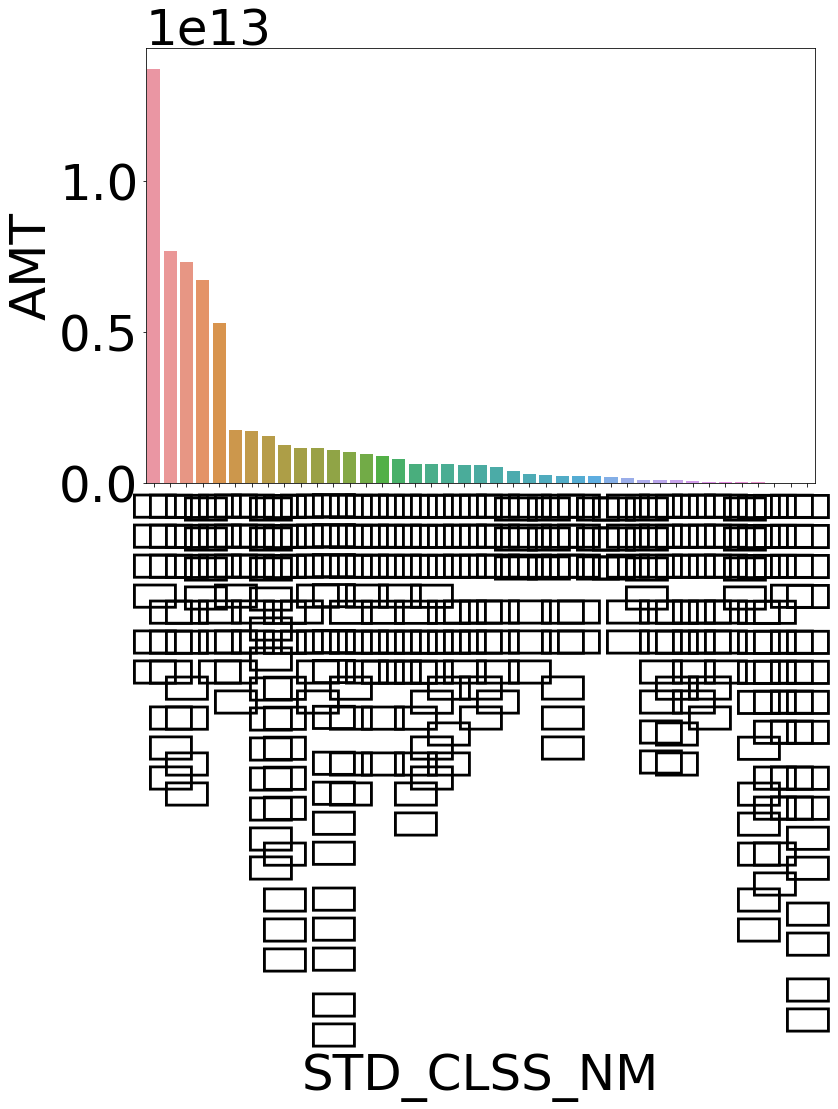

In [87]:
# 업종별 사용금액 그래프

card_std = jeju.groupby(['STD_CLSS_NM'])[['AMT','CNT','CSTMR_CNT']].sum().reset_index(drop = False)
card_std = card_std.sort_values(by=['AMT'], axis=0,ascending=False)
plt.figure(figsize = (12,8))
sns.barplot(card_std.STD_CLSS_NM, card_std.AMT)

plt.xticks(rotation='vertical')
plt.show()

업종별로 보았을 때는 한식 음식점업이 월등히 높고\
차량용 주유소 운영업-기타 대형 종합 소매업-슈퍼마켓-체인화편의점 순이다.\
10위까지를 보면 전반적으로 음식업과 소매업 그리고 운송업에 치중되어 있다.

In [ ]:
from matplotlib import pyplot as plt
sns.lineplot(x=jeju.REG_YYMM,y=TMR_CNT',data=df[df['STD_CLSS_NM']=='건강보조식품 소매업'],hue='STD_CLSS_NM')
plt.plot(x_values, y_values_1)
plt.plot(x_values, y_values_2)
plt.show()

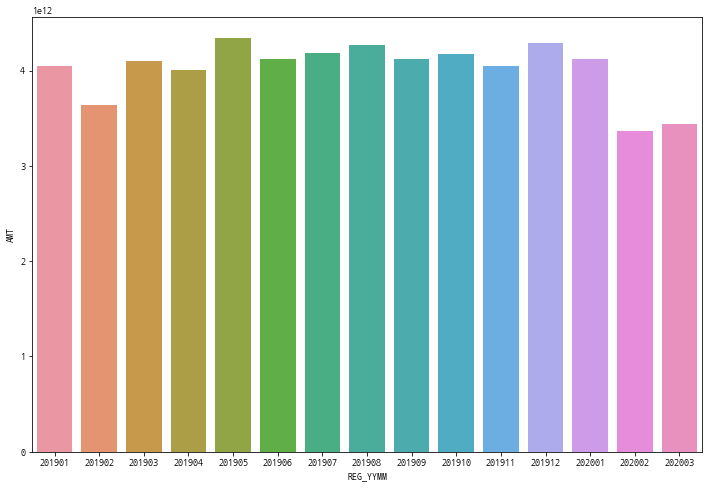

In [58]:
calendar = jeju.groupby(['REG_YYMM'])[['AMT','CNT','CSTMR_CNT']].sum().reset_index(drop = False)
plt.figure(figsize = (12,8))
sns.barplot(calendar.REG_YYMM, calendar.AMT)
plt.show()

월별 사용 금액은 비슷하지만,\
2020년 2월-3월에 급격히 줄어든 것을 볼 수 있다.

**사용금액 TOP 10 업종**

In [14]:
# card_std = jeju.groupby(['STD_CLSS_NM'])[['AMT','CNT','CSTMR_CNT']].sum().reset_index(drop = False)
card_std = jeju.groupby(['STD_CLSS_NM'])['AMT'].sum().reset_index(drop = False)
card_std = card_std.sort_values(by=['AMT'], axis=0,ascending=False)[:10]
top10_std = list(card_std.STD_CLSS_NM)

In [15]:
top_STD = jeju[jeju['STD_CLSS_NM'].isin(top10_std)]

## 업종별 분석

{'whiskers': [<matplotlib.lines.Line2D at 0x165d1c7bb48>,
 'caps': [<matplotlib.lines.Line2D at 0x165d16c2648>,
 'boxes': [<matplotlib.lines.Line2D at 0x165d1605548>],
 'medians': [<matplotlib.lines.Line2D at 0x165d16c2b48>],
 'fliers': [<matplotlib.lines.Line2D at 0x165d1876c08>],
 'means': []}

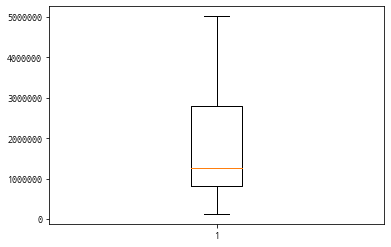

In [80]:
business_amt = jeju.groupby(['STD_CLSS_NM'])[['AMT','CNT','CSTMR_CNT']].mean().reset_index(drop = False)
plt.boxplot(business_amt['AMT'])

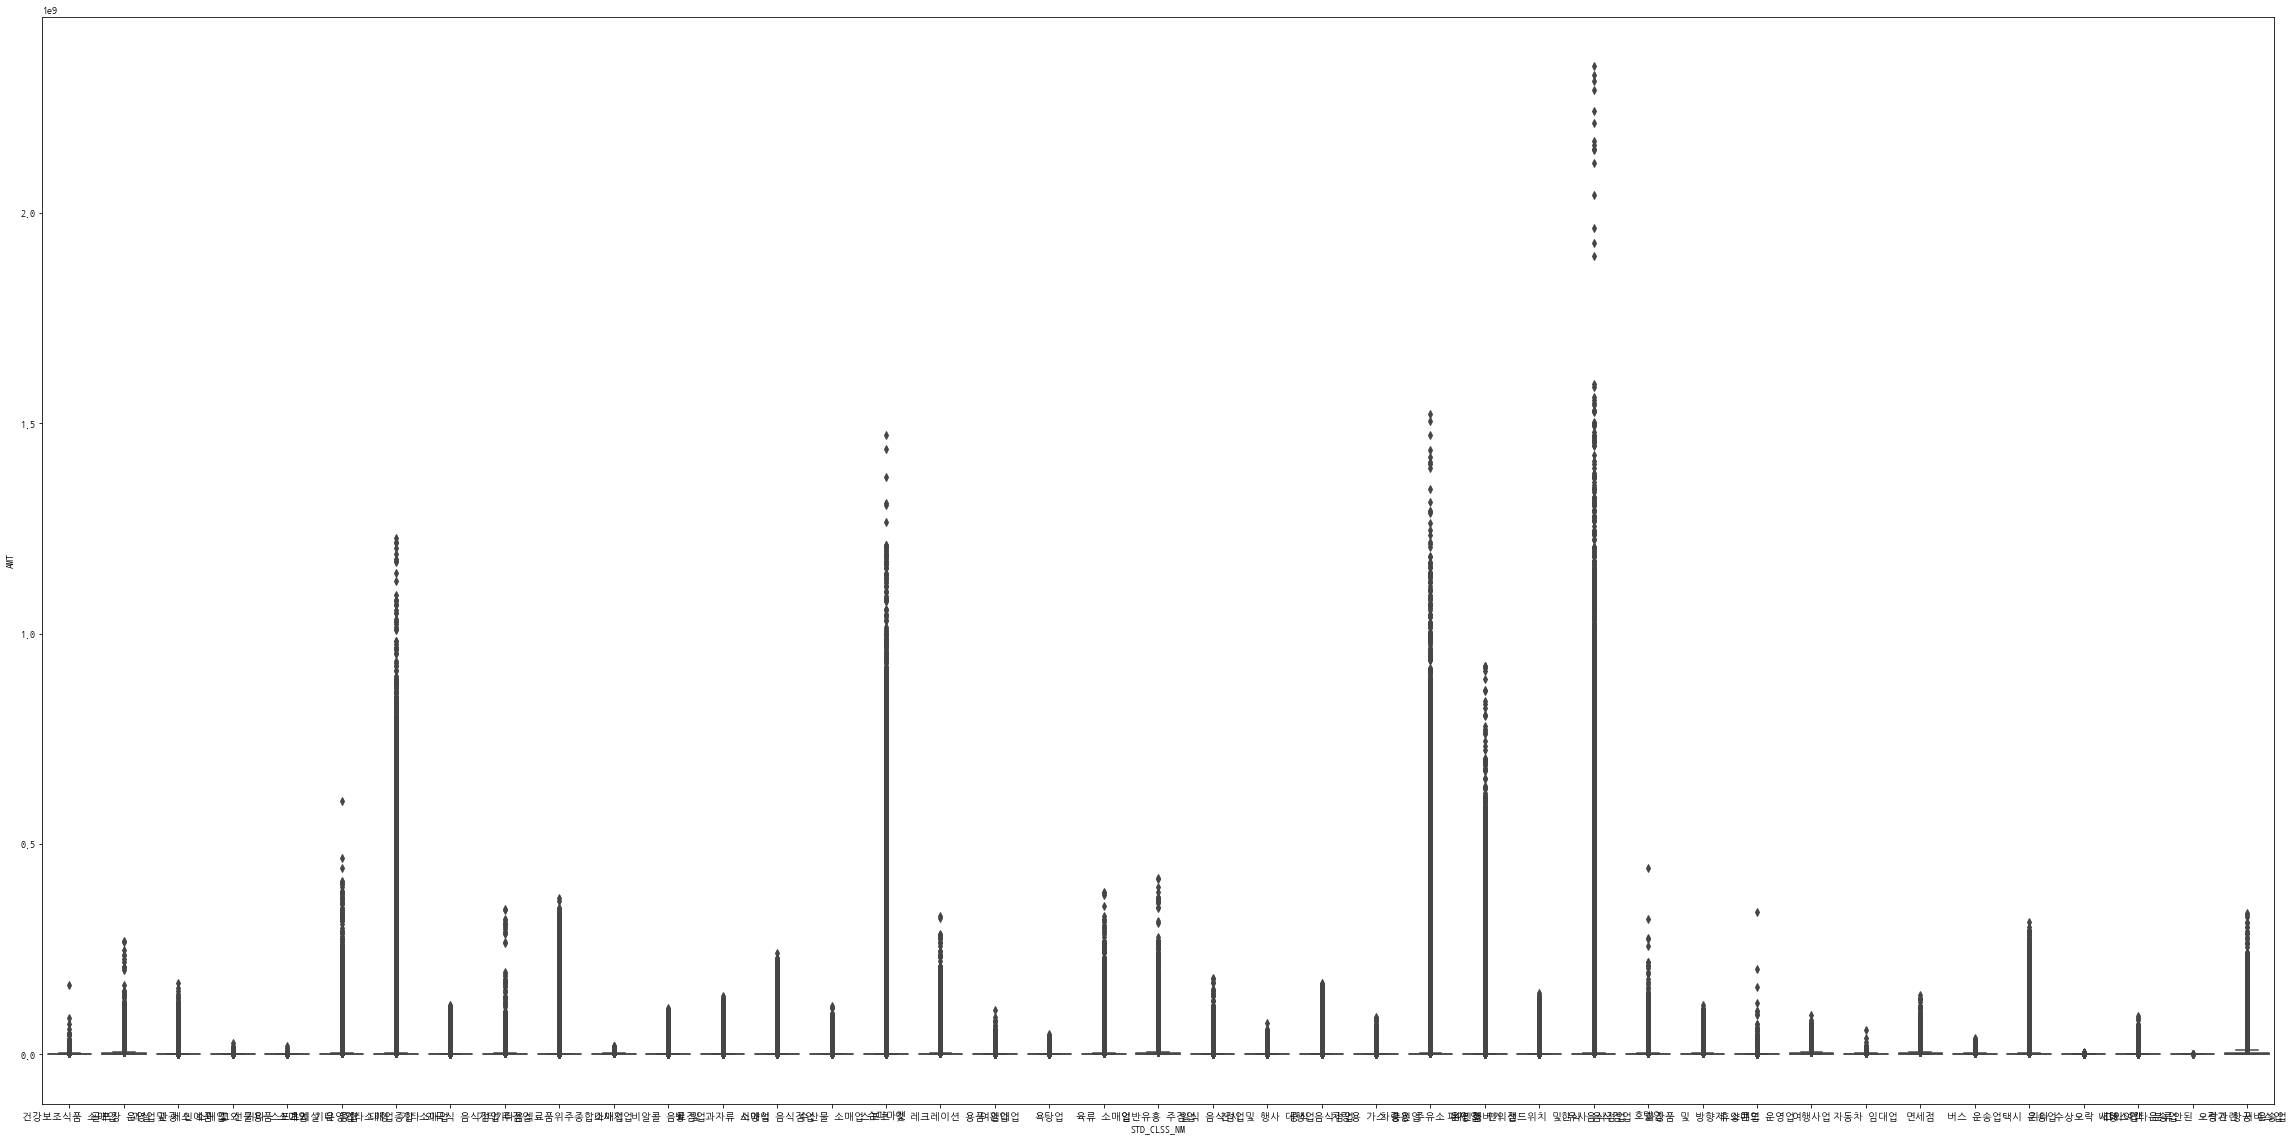

In [81]:
business_amt2 = jeju[['STD_CLSS_NM','AMT']]

plt.figure(figsize = (40,20))
ax = sns.boxplot(x = 'STD_CLSS_NM', y = 'AMT', data = business_amt2)

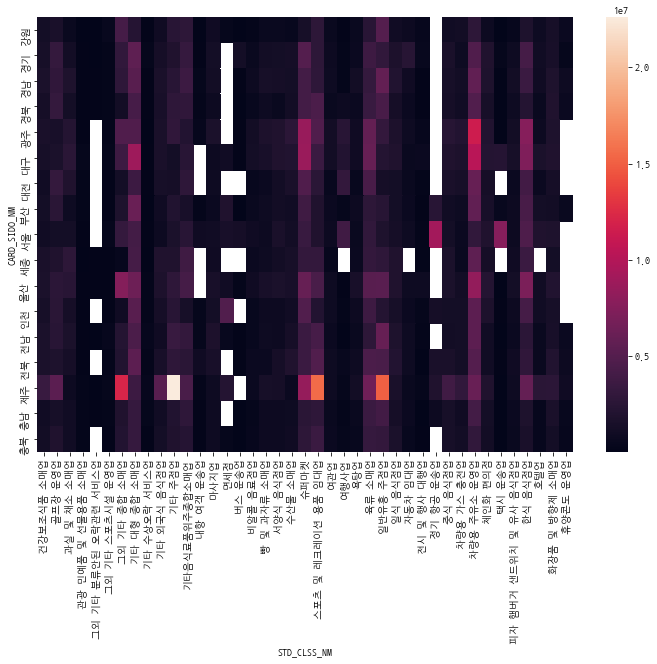

In [32]:
# jeju['AMT'] = jeju['AMT'][jeju['CARD_SIDO_NM']=='제주']*3

city_store = jeju.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].aggregate('mean').reset_index()
city_store = city_store.pivot('CARD_SIDO_NM','STD_CLSS_NM','AMT')

plt.figure(figsize=(12,8))
sns.heatmap(city_store)
plt.show()

카드 가맹점 직역 및 업종에 따른 카드 사용 금액의 평균값으로 보았을 때,\
제주의 '스포츠 및 레크레이션 용품 임대업'과 '일반유흥 주점업'이 높은 것을 볼 수 있다.

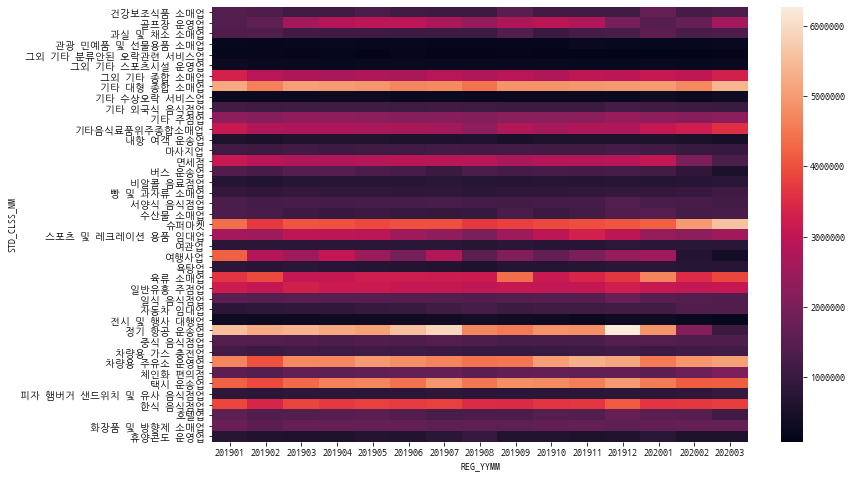

In [65]:
ym_cnt = jeju.groupby(['STD_CLSS_NM','REG_YYMM'])['AMT'].aggregate('mean').reset_index()
ym_cnt = ym_cnt.pivot('STD_CLSS_NM','REG_YYMM','AMT')

plt.figure(figsize=(12,8))
sns.heatmap(ym_cnt)
plt.show()